In [13]:
#устанавливаем библиотеку для Time-to-Event Analysis в sklearn 
!pip install scikit-survival

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


(S. Pölsterl, “scikit-survival: A Library for Time-to-Event Analysis Built on Top of scikit-learn Journal of Machine Learning Research, vol. 21, no. 212, pp. 1–6, 2020.)

In [4]:
#Разведочный анализ данных #Импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sksurv.preprocessing import OneHotEncoder, encode_categorical
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from pandas.plotting import scatter_matrix
from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,)
from sksurv.nonparametric import kaplan_meier_estimator
from sklearn import set_config
from sksurv.linear_model import CoxPHSurvivalAnalysis
%matplotlib inline 

In [6]:
#Data extraction - загружаем датасет
X_full = pd.read_csv('/content/METABRIC_RNA_Mutation.csv', low_memory=False)

In [7]:
#Трансформируем датасет с целью упрощения работы с ним. Отсеиваем генетические признаки и оставляем клинические
clinical_df = X_full.iloc[:, :31]

Так как данные являются цензурированными с правой стороны, то мы будем работать с инструментами, позволяющими строить модели, учитывающие цензурирование. Для описательных целей построим кривые Каплана-Мейера. А для анализа влияния аттрибутов/фич - модель пропорциональных рисков (Регрессия Кокса). 
Вне зависимости от выбранной библиотеки (lifelines или scikit-survival) очевидно, что в датасете Каггла неверно расставлены значения: 0 - умер, 1 - живой. 
Тогда как в действительности должно быть иначе: 1 - есть событие, т.е.смерть в данном случае, 0 - события нет (причем это и есть цензурирование). 
Данные с сайта проекта подтверждают наше предположение. https://www.cbioportal.org/study/summary?id=brca_metabric 
Итак, меняем 0 и 1 местами для целевой переменной overall_survival

In [41]:

clinical_df_inverted['overall_survival'] = clinical_df_inverted['overall_survival'].replace([0,1],[1,0])



In [44]:
KM_df = clinical_df_inverted.copy()


In [46]:
#Для работы с y и scikitsurv кодируем фичу как булеву
KM_df[['overall_survival']] = KM_df[['overall_survival']].astype(bool)


Учитывая большое количество фич, удалим неинформативные - patient_id, cohort, cancer_type (1903 это один тип), oncotree_code (он дублирует фичу cancer_type_detailed). Наверное, правильным будет удалить death_from_cancer как очевидно самую информативную для выбранных переменных, но вернемся к этому позже.

In [47]:
KM_df.drop(['patient_id', 'cohort', 'cancer_type', 'oncotree_code'], axis=1, inplace=True)

In [48]:
X = KM_df.copy()
X.drop(['overall_survival', 'overall_survival_months'], axis=1, inplace=True)

In [49]:
y = KM_df.copy()
y.columns

Index(['age_at_diagnosis', 'type_of_breast_surgery', 'cancer_type_detailed',
       'cellularity', 'chemotherapy', 'pam50_+_claudin-low_subtype',
       'er_status_measured_by_ihc', 'er_status', 'neoplasm_histologic_grade',
       'her2_status_measured_by_snp6', 'her2_status',
       'tumor_other_histologic_subtype', 'hormone_therapy',
       'inferred_menopausal_state', 'integrative_cluster',
       'primary_tumor_laterality', 'lymph_nodes_examined_positive',
       'mutation_count', 'nottingham_prognostic_index',
       'overall_survival_months', 'overall_survival', 'pr_status',
       'radio_therapy', '3-gene_classifier_subtype', 'tumor_size',
       'tumor_stage', 'death_from_cancer'],
      dtype='object')

In [50]:
#В целевой переменной - overall_survival и overall_survival_months
y.drop(['age_at_diagnosis', 'type_of_breast_surgery',
       'cancer_type_detailed', 'cellularity', 'chemotherapy',
       'pam50_+_claudin-low_subtype', 'er_status_measured_by_ihc', 'er_status',
       'neoplasm_histologic_grade', 'her2_status_measured_by_snp6',
       'her2_status', 'tumor_other_histologic_subtype', 'hormone_therapy',
       'inferred_menopausal_state', 'integrative_cluster',
       'primary_tumor_laterality', 'lymph_nodes_examined_positive',
       'mutation_count', 'nottingham_prognostic_index','pr_status',
       'radio_therapy', '3-gene_classifier_subtype', 'tumor_size',
       'tumor_stage', 'death_from_cancer'], axis=1, inplace=True)

In [51]:
y_rear = y[['overall_survival', 'overall_survival_months']]
print(y_rear)

      overall_survival  overall_survival_months
0                False               140.500000
1                False                84.633333
2                 True               163.700000
3                False               164.933333
4                 True                41.366667
...                ...                      ...
1899             False               196.866667
1900              True                44.733333
1901              True               175.966667
1902              True                86.233333
1903              True               201.900000

[1904 rows x 2 columns]


In [52]:
new_y = y_rear[['overall_survival', 'overall_survival_months']].to_numpy()
print(new_y)

[[False 140.5]
 [False 84.63333333]
 [True 163.7]
 ...
 [True 175.9666667]
 [True 86.23333333]
 [True 201.9]]


In [53]:
#Делаем структурированный массив
dt=dtype=[('overall_survival', '?'), ('overall_survival_months', '<f8')]

#Structured array
struct_y = np.array([tuple(row) for row in new_y], dtype=dt)
struct_y

array([(False, 140.5       ), (False,  84.63333333),
       ( True, 163.7       ), ..., ( True, 175.9666667 ),
       ( True,  86.23333333), ( True, 201.9       )],
      dtype=[('overall_survival', '?'), ('overall_survival_months', '<f8')])

In [54]:
num_columns = [cname for cname in X.columns if 
                X[cname].dtype in ['int64', 'float64']]
print(num_columns)

['age_at_diagnosis', 'chemotherapy', 'neoplasm_histologic_grade', 'hormone_therapy', 'lymph_nodes_examined_positive', 'mutation_count', 'nottingham_prognostic_index', 'radio_therapy', 'tumor_size', 'tumor_stage']


In [55]:
cat_columns = [cname for cname in X.columns if
                    X[cname].dtype == "object"]
print(cat_columns)

['type_of_breast_surgery', 'cancer_type_detailed', 'cellularity', 'pam50_+_claudin-low_subtype', 'er_status_measured_by_ihc', 'er_status', 'her2_status_measured_by_snp6', 'her2_status', 'tumor_other_histologic_subtype', 'inferred_menopausal_state', 'integrative_cluster', 'primary_tumor_laterality', 'pr_status', '3-gene_classifier_subtype', 'death_from_cancer']


In [56]:
#проведем column transformer до train-test split
num_pipeline = Pipeline([
    ('std_scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy='median')),
])

In [57]:
cat_pipeline = Pipeline([
    ('oe', OrdinalEncoder()),
])

In [58]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_columns),
        ('cat', cat_pipeline, cat_columns)
    ], remainder='passthrough')

In [59]:
preprocessor.set_output(transform='pandas')
X_pandas = preprocessor.fit_transform(X)
X_pandas

,num__age_at_diagnosis,num__chemotherapy,num__neoplasm_histologic_grade,num__hormone_therapy,num__lymph_nodes_examined_positive,num__mutation_count,num__nottingham_prognostic_index,num__radio_therapy,num__tumor_size,num__tumor_stage,...,cat__er_status,cat__her2_status_measured_by_snp6,cat__her2_status,cat__tumor_other_histologic_subtype,cat__inferred_menopausal_state,cat__integrative_cluster,cat__primary_tumor_laterality,cat__pr_status,cat__3-gene_classifier_subtype,cat__death_from_cancer
0,1.122359,-0.512445,0.897956,0.788547,1.960788,-0.171942,1.757557,0.821330,-0.279656,0.396748,...,1.0,2.0,0.0,0.0,0.0,4.0,1.0,0.0,2.0,2.0
1,-1.379317,-0.512445,0.897956,0.788547,-0.490841,-0.911280,-0.011378,0.821330,-1.071371,-1.193646,...,1.0,2.0,0.0,0.0,1.0,4.0,1.0,1.0,0.0,2.0
2,-0.941562,1.951430,-0.639479,0.788547,-0.245678,-0.911280,-0.002638,-1.217538,-0.741490,0.396748,...,1.0,2.0,0.0,0.0,1.0,3.0,1.0,1.0,NaN,0.0
3,-1.033275,1.951430,-0.639479,0.788547,0.244648,-1.157725,0.014841,0.821330,-0.081727,0.396748,...,1.0,2.0,0.0,4.0,1.0,10.0,1.0,1.0,NaN,2.0
4,1.224091,1.951430,0.897956,0.788547,1.470462,-0.911280,1.789021,0.821330,0.907918,0.396748,...,1.0,2.0,0.0,4.0,0.0,10.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1899,-1.386253,-0.512445,0.897956,0.788547,-0.245678,-0.418388,0.888821,0.821330,-0.081727,0.396748,...,1.0,2.0,0.0,1.0,1.0,3.0,1.0,1.0,1.0,2.0
1900,-1.403208,-0.512445,0.897956,-1.268156,-0.245678,0.074504,0.880081,0.821330,-0.411608,0.396748,...,1.0,0.0,1.0,0.0,1.0,6.0,NaN,0.0,NaN,0.0
1901,0.139723,-0.512445,0.897956,0.788547,10.541487,-0.418388,1.762801,0.821330,-0.081727,0.396748,...,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,0.0
1902,0.005622,-0.512445,-0.639479,0.788547,2.451113,2.292516,0.888821,-1.217538,-0.081727,0.396748,...,1.0,2.0,0.0,0.0,0.0,0.0,NaN,1.0,0.0,1.0


In [60]:
X_train, X_test, struct_y_train, struct_y_test = train_test_split(X_pandas, struct_y, 
                                                                train_size=0.8, test_size=0.2,
                                                                random_state=0)

Text(0.5, 0, 'time')

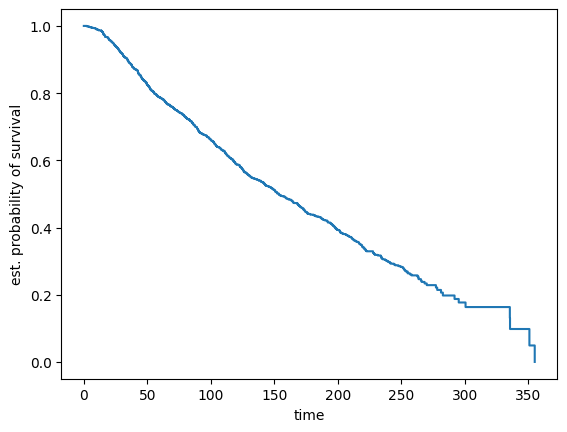

In [61]:
#Построим кривую КМ
time, survival_prob = kaplan_meier_estimator(struct_y_train["overall_survival"], struct_y_train["overall_survival_months"])
plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability of survival")
plt.xlabel("time")

In [62]:
X_train["cat__integrative_cluster"].value_counts()

9.0     222
3.0     219
4.0     208
1.0     168
6.0     153
8.0     150
10.0    115
0.0     102
7.0      68
2.0      62
5.0      56
Name: cat__integrative_cluster, dtype: int64

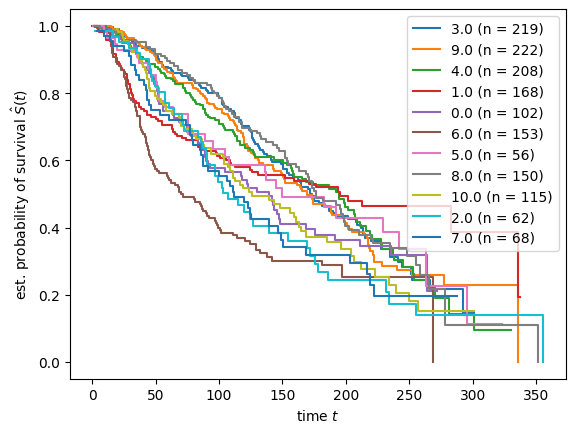

In [63]:
for value in X_train["cat__integrative_cluster"].unique():
    mask = X_train["cat__integrative_cluster"] == value
    time_grade, survival_prob_grade = kaplan_meier_estimator(struct_y_train["overall_survival"][mask],
                                                           struct_y_train["overall_survival_months"][mask])
    plt.step(time_grade, survival_prob_grade, where="post",
             label="%s (n = %d)" % (value, mask.sum()))
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

In [64]:
#Можно проводить подгрупповой анализ и сравнивать различия при помощи лог-ранкового теста, но для того, чтобы учесть сразу все признаки, нам нужна модель пропорциональных рисков.
X_train = X_train.fillna(X_train.median())

In [65]:
X_test = X_test.fillna(X_test.median())

In [66]:
from sklearn import set_config
from sksurv.linear_model import CoxPHSurvivalAnalysis

set_config(display="text")  # displays text representation of estimators

estimator = CoxPHSurvivalAnalysis()
estimator.fit(X_train, struct_y_train)
CoxPHSurvivalAnalysis()

CoxPHSurvivalAnalysis()

In [67]:
pd.Series(estimator.coef_, index=X_train.columns)

num__age_at_diagnosis                  0.485499
num__chemotherapy                      0.130871
num__neoplasm_histologic_grade        -0.008600
num__hormone_therapy                   0.031980
num__lymph_nodes_examined_positive     0.070330
num__mutation_count                    0.012590
num__nottingham_prognostic_index       0.036380
num__radio_therapy                    -0.079629
num__tumor_size                        0.050466
num__tumor_stage                       0.115715
cat__type_of_breast_surgery           -0.023190
cat__cancer_type_detailed              0.098371
cat__cellularity                      -0.046094
cat__pam50_+_claudin-low_subtype      -0.034079
cat__er_status_measured_by_ihc        -0.100438
cat__er_status                        -0.599246
cat__her2_status_measured_by_snp6     -0.184157
cat__her2_status                       0.050821
cat__tumor_other_histologic_subtype   -0.108593
cat__inferred_menopausal_state         0.328219
cat__integrative_cluster              -0

In [68]:
KM_pred = pd.DataFrame.from_dict({
    1: [1.122359, -0.512445, 0.867685, 0.788547, 1.960788, -0.169839, 1.757557, 0.821330, -0.278813, 0.333732, 1.0, 1.0, 0.0, 6.0, 1.0, 1.0, 2.0, 0.0, 4.0, 0.0, 9.0, 1.0, 1.0, 0.0, 0.0],
    2: [-0.941562, 1.951430, -0.676308, 0.788547, -0.245678, -0.917810, -0.002638, -1.217538, -0.742981, 0.333732, 1.0, 4.0, 2.0, 3.0, 1.0, 1.0, 2.0, 0.0, 4.0, 0.0, 4.0, 1.0, 1.0, 0.0, 2.0],
    3: [-1.033275, 1.951430, -0.676308, 0.788547, 0.244648, -1.167134, 0.014841, 0.821330, -0.079884, 0.333732, 1.0, 1.0, 2.0, 6.0, 1.0, 1.0, 2.0, 0.0, 4.0, 0.0, 10.0, 1.0, 1.0, 0.0, 0.0],
    4: [1.224091, 1.951430, 0.867685, 0.788547, 1.470462, -0.917810, 1.789021, 0.821330, 0.914762, 0.333732, 1.0, 1.0, 0.0, 6.0, 1.0, 1.0, 2.0, 0.0, 4.0, 0.0, 9.0, 1.0, 1.0, 0.0, 0.0]},
     columns=X_test.columns, orient='index')
KM_pred

,num__age_at_diagnosis,num__chemotherapy,num__neoplasm_histologic_grade,num__hormone_therapy,num__lymph_nodes_examined_positive,num__mutation_count,num__nottingham_prognostic_index,num__radio_therapy,num__tumor_size,num__tumor_stage,...,cat__er_status,cat__her2_status_measured_by_snp6,cat__her2_status,cat__tumor_other_histologic_subtype,cat__inferred_menopausal_state,cat__integrative_cluster,cat__primary_tumor_laterality,cat__pr_status,cat__3-gene_classifier_subtype,cat__death_from_cancer
1,1.122359,-0.512445,0.867685,0.788547,1.960788,-0.169839,1.757557,0.821330,-0.278813,0.333732,...,1.0,2.0,0.0,4.0,0.0,9.0,1.0,1.0,0.0,0.0
2,-0.941562,1.951430,-0.676308,0.788547,-0.245678,-0.917810,-0.002638,-1.217538,-0.742981,0.333732,...,1.0,2.0,0.0,4.0,0.0,4.0,1.0,1.0,0.0,2.0
3,-1.033275,1.951430,-0.676308,0.788547,0.244648,-1.167134,0.014841,0.821330,-0.079884,0.333732,...,1.0,2.0,0.0,4.0,0.0,10.0,1.0,1.0,0.0,0.0
4,1.224091,1.951430,0.867685,0.788547,1.470462,-0.917810,1.789021,0.821330,0.914762,0.333732,...,1.0,2.0,0.0,4.0,0.0,9.0,1.0,1.0,0.0,0.0


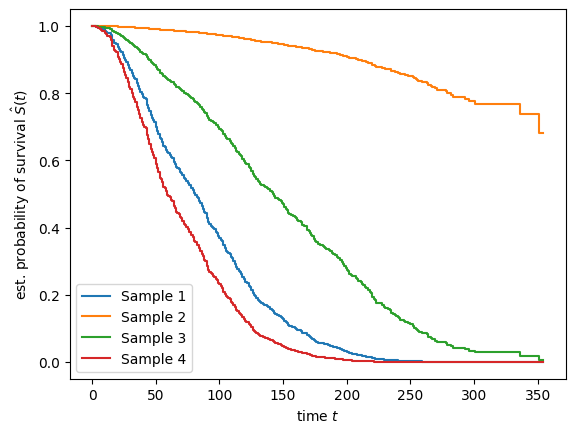

In [69]:
pred_surv = estimator.predict_survival_function(KM_pred)
time_points = np.arange(0, 355)
for i, surv_func in enumerate(pred_surv):
    plt.step(time_points, surv_func(time_points), where="post",
             label="Sample %d" % (i + 1))
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

In [70]:
#Измеряем Harrell’s concordance index or c-index.
from sksurv.metrics import concordance_index_censored

In [71]:
prediction = estimator.predict(X_test)
result = concordance_index_censored(struct_y_test["overall_survival"], struct_y_test["overall_survival_months"], prediction)
result[0]

0.8378183799350106

In [72]:
#то же самое
estimator.score(X_test, struct_y_test)

0.8378183799350106

In [73]:
#feature selection
def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j:j+1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores

scores = fit_and_score_features(X_test.values, struct_y_test)
pd.Series(scores, index=X_test.columns).sort_values(ascending=False)

cat__death_from_cancer                 0.813584
num__nottingham_prognostic_index       0.653552
num__tumor_size                        0.626544
num__lymph_nodes_examined_positive     0.619861
num__age_at_diagnosis                  0.601891
num__tumor_stage                       0.590635
cat__type_of_breast_surgery            0.569659
num__neoplasm_histologic_grade         0.569173
cat__primary_tumor_laterality          0.544821
cat__pr_status                         0.544082
num__chemotherapy                      0.538274
cat__pam50_+_claudin-low_subtype       0.537048
cat__integrative_cluster               0.536231
cat__her2_status_measured_by_snp6      0.535803
cat__er_status                         0.529537
cat__er_status_measured_by_ihc         0.529294
num__hormone_therapy                   0.522386
cat__inferred_menopausal_state         0.520256
cat__tumor_other_histologic_subtype    0.515751
num__mutation_count                    0.514720
cat__her2_status                       0

Здесь можно сказать, что модель неплохо предсказывает, но есть большие сомнения по признаку death_from_cancer (см. выше). Попробуем его убрать и посмотрим результат.

In [74]:
X_train_24 = X_train.copy()
X_train_24.drop(['cat__death_from_cancer'], axis=1, inplace=True)
X_test_24 = X_test.copy()
X_test_24.drop(['cat__death_from_cancer'], axis=1, inplace=True)

In [75]:
estimator = CoxPHSurvivalAnalysis()
estimator.fit(X_train_24, struct_y_train)
CoxPHSurvivalAnalysis()

CoxPHSurvivalAnalysis()

In [76]:
pd.Series(estimator.coef_, index=X_train_24.columns)

num__age_at_diagnosis                  0.616873
num__chemotherapy                      0.103034
num__neoplasm_histologic_grade         0.012524
num__hormone_therapy                  -0.032384
num__lymph_nodes_examined_positive     0.166757
num__mutation_count                    0.005315
num__nottingham_prognostic_index       0.122917
num__radio_therapy                    -0.123152
num__tumor_size                        0.100879
num__tumor_stage                       0.123945
cat__type_of_breast_surgery            0.062720
cat__cancer_type_detailed              0.144746
cat__cellularity                      -0.001466
cat__pam50_+_claudin-low_subtype       0.006389
cat__er_status_measured_by_ihc        -0.016720
cat__er_status                        -0.380466
cat__her2_status_measured_by_snp6     -0.073717
cat__her2_status                       0.407796
cat__tumor_other_histologic_subtype   -0.092564
cat__inferred_menopausal_state         0.418152
cat__integrative_cluster               0

In [77]:
KM_pred_24 = pd.DataFrame.from_dict({
    1: [1.122359, -0.512445, 0.867685, 0.788547, 1.960788, -0.169839, 1.757557, 0.821330, -0.278813, 0.333732, 1.0, 1.0, 0.0, 6.0, 1.0, 1.0, 2.0, 0.0, 4.0, 0.0, 9.0, 1.0, 1.0, 0.0],
    2: [-0.941562, 1.951430, -0.676308, 0.788547, -0.245678, -0.917810, -0.002638, -1.217538, -0.742981, 0.333732, 1.0, 4.0, 2.0, 3.0, 1.0, 1.0, 2.0, 0.0, 4.0, 0.0, 4.0, 1.0, 1.0, 0.0],
    3: [-1.033275, 1.951430, -0.676308, 0.788547, 0.244648, -1.167134, 0.014841, 0.821330, -0.079884, 0.333732, 1.0, 1.0, 2.0, 6.0, 1.0, 1.0, 2.0, 0.0, 4.0, 0.0, 10.0, 1.0, 1.0, 0.0],
    4: [1.224091, 1.951430, 0.867685, 0.788547, 1.470462, -0.917810, 1.789021, 0.821330, 0.914762, 0.333732, 1.0, 1.0, 0.0, 6.0, 1.0, 1.0, 2.0, 0.0, 4.0, 0.0, 9.0, 1.0, 1.0, 0.0]},
     columns=X_test_24.columns, orient='index')
KM_pred_24

,num__age_at_diagnosis,num__chemotherapy,num__neoplasm_histologic_grade,num__hormone_therapy,num__lymph_nodes_examined_positive,num__mutation_count,num__nottingham_prognostic_index,num__radio_therapy,num__tumor_size,num__tumor_stage,...,cat__er_status_measured_by_ihc,cat__er_status,cat__her2_status_measured_by_snp6,cat__her2_status,cat__tumor_other_histologic_subtype,cat__inferred_menopausal_state,cat__integrative_cluster,cat__primary_tumor_laterality,cat__pr_status,cat__3-gene_classifier_subtype
1,1.122359,-0.512445,0.867685,0.788547,1.960788,-0.169839,1.757557,0.821330,-0.278813,0.333732,...,1.0,1.0,2.0,0.0,4.0,0.0,9.0,1.0,1.0,0.0
2,-0.941562,1.951430,-0.676308,0.788547,-0.245678,-0.917810,-0.002638,-1.217538,-0.742981,0.333732,...,1.0,1.0,2.0,0.0,4.0,0.0,4.0,1.0,1.0,0.0
3,-1.033275,1.951430,-0.676308,0.788547,0.244648,-1.167134,0.014841,0.821330,-0.079884,0.333732,...,1.0,1.0,2.0,0.0,4.0,0.0,10.0,1.0,1.0,0.0
4,1.224091,1.951430,0.867685,0.788547,1.470462,-0.917810,1.789021,0.821330,0.914762,0.333732,...,1.0,1.0,2.0,0.0,4.0,0.0,9.0,1.0,1.0,0.0


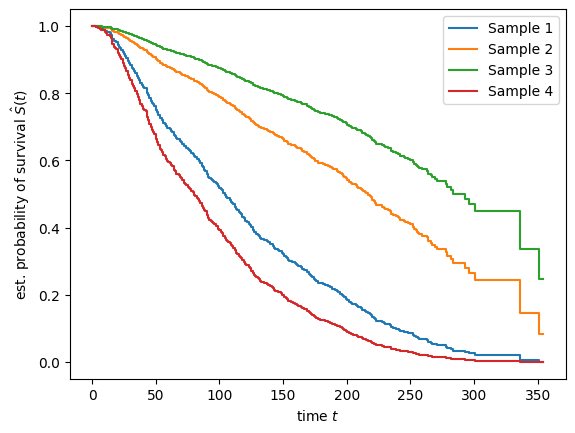

In [78]:
pred_surv = estimator.predict_survival_function(KM_pred_24)
time_points = np.arange(0, 355)
for i, surv_func in enumerate(pred_surv):
    plt.step(time_points, surv_func(time_points), where="post",
             label="Sample %d" % (i + 1))
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

In [79]:
prediction = estimator.predict(X_test_24)
result = concordance_index_censored(struct_y_test["overall_survival"], struct_y_test["overall_survival_months"], prediction)
result[0]

0.6898215710310742

что и требовалось доказать...

In [85]:
#Выберем лучшие признаки


In [81]:
X_pandas_24 = X_pandas.copy()
X_pandas_24.drop(['cat__death_from_cancer'], axis=1, inplace=True)

In [86]:
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline

pipe = Pipeline([('select', SelectKBest(fit_and_score_features, k=3)),
                 ('model', CoxPHSurvivalAnalysis())])

In [87]:
from sklearn.model_selection import GridSearchCV, KFold

param_grid = {'select__k': np.arange(1, X_pandas_24.shape[1] + 1)}
cv = KFold(n_splits=3, random_state=1, shuffle=True)
gcv = GridSearchCV(pipe, param_grid, return_train_score=True, cv=cv)
gcv.fit(X_pandas_24, struct_y)

results = pd.DataFrame(gcv.cv_results_).sort_values(by='mean_test_score', ascending=False)
results.loc[:, ~results.columns.str.endswith("_time")]


,param_select__k,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
19,20,{'select__k': 20},0.702306,0.671426,0.656342,0.676691,0.019131,1,0.678388,0.682688,0.687324,0.682800,0.003649
20,21,{'select__k': 21},0.700333,0.672582,0.656898,0.676604,0.017959,2,0.677759,0.683355,0.687284,0.682799,0.003908
23,24,{'select__k': 24},0.698985,0.670510,0.659970,0.676489,0.016479,3,0.679646,0.685026,0.690317,0.684997,0.004357
22,23,{'select__k': 23},0.700473,0.671312,0.656606,0.676130,0.018230,4,0.679344,0.683129,0.688883,0.683785,0.003922
21,22,{'select__k': 22},0.700576,0.671007,0.656741,0.676108,0.018255,5,0.677945,0.683641,0.686766,0.682784,0.003652
18,19,{'select__k': 19},0.700554,0.671426,0.655208,0.675729,0.018761,6,0.677229,0.682556,0.686364,0.682050,0.003746
17,18,{'select__k': 18},0.700679,0.669304,0.654980,0.674988,0.019084,7,0.677167,0.682471,0.685999,0.681879,0.003630
16,17,{'select__k': 17},0.699059,0.667303,0.654994,0.673785,0.018564,8,0.673583,0.681933,0.685969,0.680495,0.005158
15,16,{'select__k': 16},0.698823,0.667885,0.654431,0.673713,0.018586,9,0.673586,0.682112,0.685835,0.680511,0.005127
13,14,{'select__k': 14},0.700333,0.664521,0.651936,0.672263,0.020502,10,0.669485,0.680081,0.686622,0.678729,0.007061


In [95]:
pipe.set_params(**gcv.best_params_)
pipe.fit(X_pandas_24, struct_y)

transformer, final_estimator = [s[1] for s in pipe.steps]
print("Best estimator found:")
print(gcv.best_estimator_)

Best estimator found:
Pipeline(steps=[('select',
                 SelectKBest(k=20,
                             score_func=<function fit_and_score_features at 0x7f1bbc21b790>)),
                ('model', CoxPHSurvivalAnalysis())])


In [97]:
print("Best score:")
print(gcv.best_score_)

Best score:
0.6766913170357925


In [101]:
print(gcv.best_params_)

{'select__k': 20}


In [ ]:
#Попробуем гребневую регрессию?? (Penalized Cox Model), которая позволяет улучшить результаты при большом количестве признаков

In [106]:
def plot_coefficients(coefs, n_highlight):
    _, ax = plt.subplots(figsize=(8, 6))
    n_features = coefs.shape[0]
    alphas = coefs.columns
    for row in coefs.itertuples():
        ax.semilogx(alphas, row[1:], ".-", label=row.Index)

    alpha_min = alphas.min()
    top_coefs = coefs.loc[:, alpha_min].map(abs).sort_values().tail(n_highlight)
    for name in top_coefs.index:
        coef = coefs.loc[name, alpha_min]
        plt.text(
            alpha_min, coef, name + "   ",
            horizontalalignment="right",
            verticalalignment="center"
        )

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.grid(True)
    ax.set_xlabel("alpha")
    ax.set_ylabel("coefficient")

In [104]:
alphas = 10. ** np.linspace(-4, 4, 50)
coefficients = {}

cph = CoxPHSurvivalAnalysis()
for alpha in alphas:
    cph.set_params(alpha=alpha)
    cph.fit(X_train_24, struct_y_train)
    key = round(alpha, 5)
    coefficients[key] = cph.coef_

coefficients = (pd.DataFrame
    .from_dict(coefficients)
    .rename_axis(index="feature", columns="alpha")
    .set_index(X_train_24.columns))

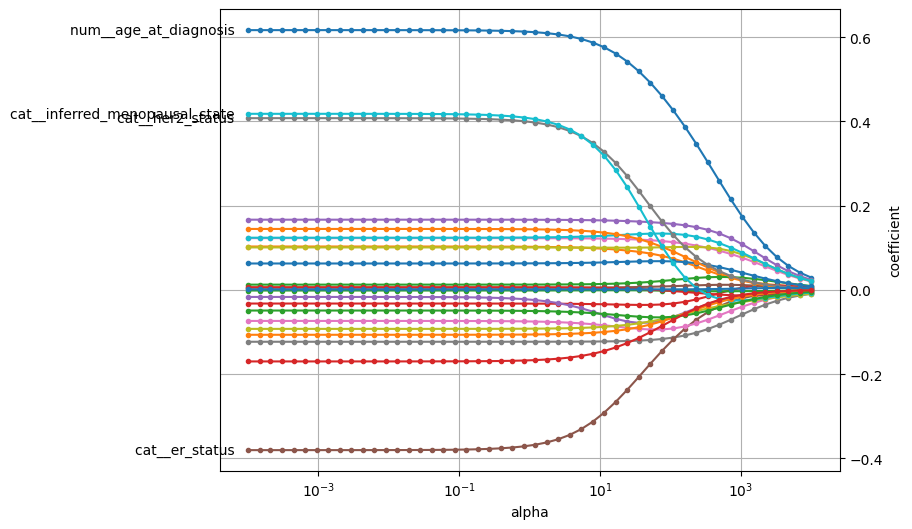

In [107]:
plot_coefficients(coefficients, n_highlight=4)

In [108]:
#Попробуем построить регрессию Лассо
from sksurv.linear_model import CoxnetSurvivalAnalysis

In [109]:
cox_lasso = CoxnetSurvivalAnalysis(l1_ratio=1.0, alpha_min_ratio=0.01)
cox_lasso.fit(X_train_24, struct_y_train)

CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, l1_ratio=1.0)

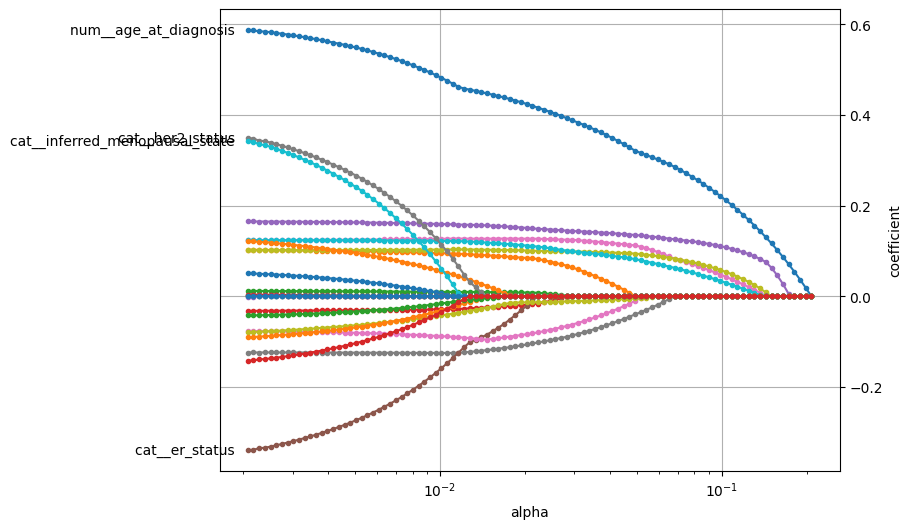

In [110]:
coefficients_lasso = pd.DataFrame(
    cox_lasso.coef_,
    index=X_train_24.columns,
    columns=np.round(cox_lasso.alphas_, 5)
)

plot_coefficients(coefficients_lasso, n_highlight=4)

In [111]:
#эластичная сеть
cox_elastic_net = CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01)
cox_elastic_net.fit(X_train_24, struct_y_train)

CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, l1_ratio=0.9)

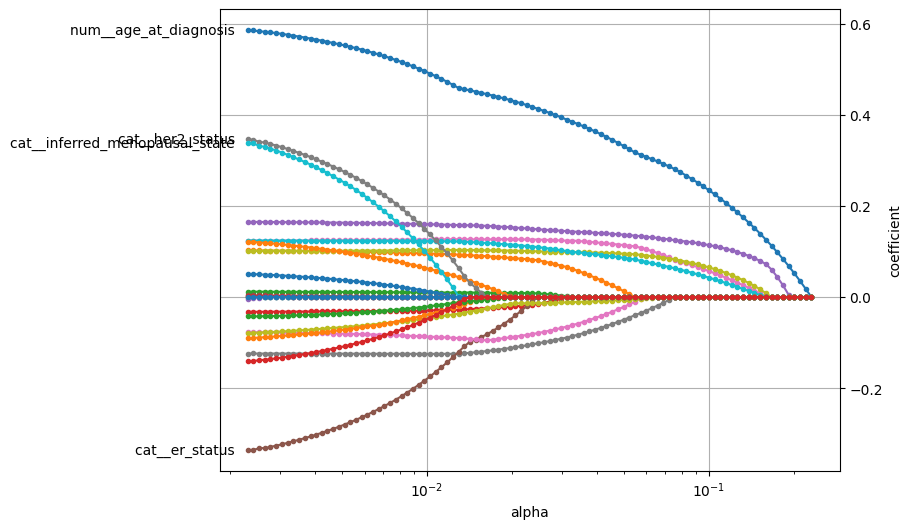

In [112]:
coefficients_elastic_net = pd.DataFrame(
    cox_elastic_net.coef_,
    index=X_train_24.columns,
    columns=np.round(cox_elastic_net.alphas_, 5)
)

plot_coefficients(coefficients_elastic_net, n_highlight=4)

In [113]:
import warnings
from sklearn.exceptions import FitFailedWarning
from sklearn.pipeline import make_pipeline
coxnet_pipe = make_pipeline(
    StandardScaler(),
    CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01, max_iter=100)
)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FitFailedWarning)
coxnet_pipe.fit(X_pandas_24, struct_y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('coxnetsurvivalanalysis',
                 CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, l1_ratio=0.9,
                                        max_iter=100))])

In [115]:
estimated_alphas = coxnet_pipe.named_steps["coxnetsurvivalanalysis"].alphas_
cv = KFold(n_splits=5, shuffle=True, random_state=0)
gcv = GridSearchCV(
    make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.9)),
    param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in estimated_alphas]},
    cv=cv,
    error_score=0.5,
    n_jobs=1).fit(X_pandas_24, struct_y)

cv_results = pd.DataFrame(gcv.cv_results_)

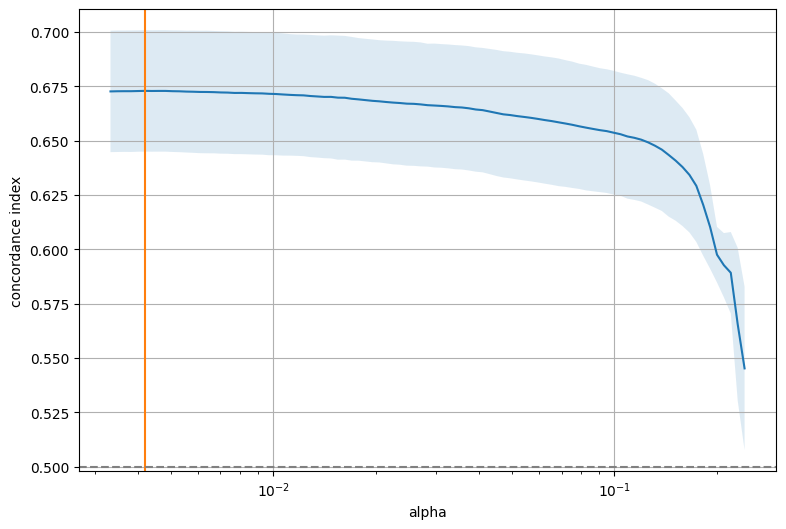

In [116]:
alphas = cv_results.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score
std = cv_results.std_test_score

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(alphas, mean)
ax.fill_between(alphas, mean - std, mean + std, alpha=.15)
ax.set_xscale("log")
ax.set_ylabel("concordance index")
ax.set_xlabel("alpha")
ax.axvline(gcv.best_params_["coxnetsurvivalanalysis__alphas"][0], c="C1")
ax.axhline(0.5, color="grey", linestyle="--")
ax.grid(True)

Number of non-zero coefficients: 23


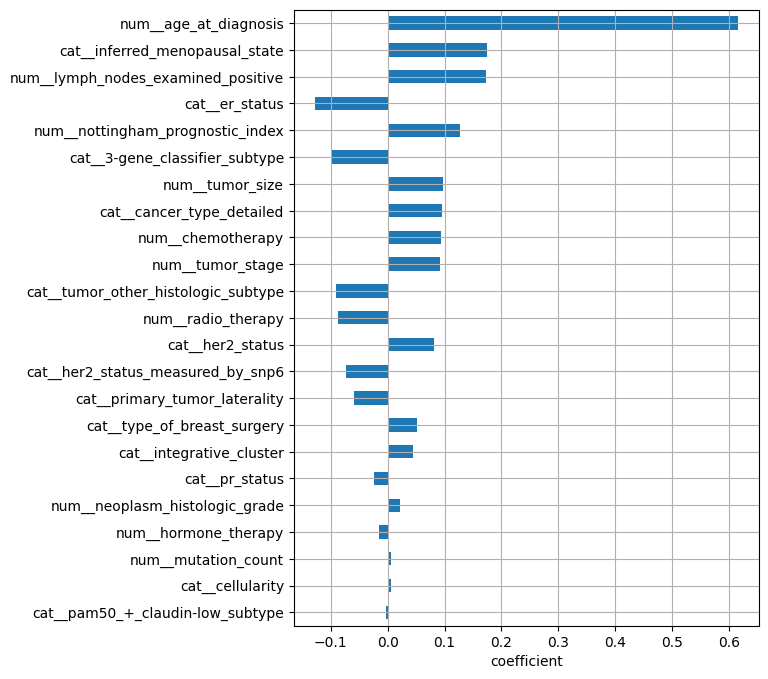

In [117]:
best_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]
best_coefs = pd.DataFrame(
    best_model.coef_,
    index=X_pandas_24.columns,
    columns=["coefficient"]
)

non_zero = np.sum(best_coefs.iloc[:, 0] != 0)
print("Number of non-zero coefficients: {}".format(non_zero))

non_zero_coefs = best_coefs.query("coefficient != 0")
coef_order = non_zero_coefs.abs().sort_values("coefficient").index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.grid(True)

In [118]:
coxnet_pred = make_pipeline(
    StandardScaler(),
    CoxnetSurvivalAnalysis(l1_ratio=0.9, fit_baseline_model=True)
)
coxnet_pred.set_params(**gcv.best_params_)
coxnet_pred.fit(X_pandas_24, struct_y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('coxnetsurvivalanalysis',
                 CoxnetSurvivalAnalysis(alphas=[0.004204671322862972],
                                        fit_baseline_model=True,
                                        l1_ratio=0.9))])

Начинаем работу с генетическими данными (убираем при этом столбцы, где обозначается конкретная мутация, так как эти данные нам пока не проанализировать)

In [120]:
gene_df = X_full.iloc[:,31:520]

In [121]:
gene_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1904 entries, 0 to 1903
Columns: 489 entries, brca1 to ugt2b7
dtypes: float64(489)
memory usage: 7.1 MB


In [123]:
X_train_gen, X_test_gen, y_train_gen, y_test_gen = train_test_split(gene_df, struct_y, 
                                                                train_size=0.8, test_size=0.2,
                                                                random_state=0)

In [124]:
estimator = CoxPHSurvivalAnalysis()
estimator.fit(X_train_gen, y_train_gen)
CoxPHSurvivalAnalysis()

CoxPHSurvivalAnalysis()

In [125]:
pd.Series(estimator.coef_, index=X_train_gen.columns)

brca1      0.064291
brca2      0.041277
palb2     -0.122005
pten      -0.028520
tp53       0.002520
             ...   
tnk2       0.009542
tulp4     -0.088221
ugt2b15   -0.140045
ugt2b17   -0.124352
ugt2b7     0.031071
Length: 489, dtype: float64

In [128]:
KM_pred_gen = pd.DataFrame.from_dict({
    1: [2.11821542e-01, -8.77575497e-01,  2.76858655e-01,
        -2.61652838e-01, -3.85723334e-01,  1.70329439e-01,
        -8.21208295e-01, -4.86766186e-01,  7.15408859e-01,
        -1.05426731e-01,  6.94128486e-01,  8.01145367e-01,
         9.86655448e-01, -6.46595165e-01,  7.50190338e-01,
        -3.17969416e-01,  6.40020426e-01, -3.32076666e-01,
         9.65792202e-01, -7.61227917e-01,  3.03180080e-01,
         3.87956214e-01,  2.09789709e-01,  3.31547399e-01,
         6.09610661e-01,  8.99132816e-03, -8.98195734e-01,
         7.30992964e-01,  4.53309361e-01, -8.22201333e-01,
        -9.67631049e-01, -3.17507373e-01, -9.96678995e-01,
         2.72296522e-01, -9.17663991e-01,  4.08074129e-01,
        -3.07577671e-01, -8.84600441e-01, -5.50508073e-01,
        -2.15734641e-01,  3.71977412e-01, -7.30837439e-01,
        -9.73732364e-01, -5.91343621e-01, -4.90897973e-01,
         3.08684705e-01,  5.39596269e-01,  7.88448548e-01,
        -5.87722969e-01, -4.28653637e-01,  6.18063198e-01,
         4.65110899e-02, -7.83173005e-01,  4.19292783e-01,
        -5.12190398e-01, -3.65282775e-02,  8.99619333e-01,
         2.24840546e-01, -9.03090807e-01, -3.93775664e-01,
         9.20225428e-01, -2.21604612e-01, -4.73970680e-01,
         6.05823638e-01,  3.09412731e-01,  3.21994065e-01,
        -5.00525989e-01, -4.49460167e-01,  4.84730574e-02,
         2.80841356e-01,  8.64317859e-01, -1.40517351e-02,
         3.11188321e-01,  8.22723527e-01, -7.22551864e-01,
         6.29078371e-01, -5.44275566e-01,  2.36317925e-01,
        -8.26591927e-01,  9.86638239e-01,  5.45848040e-01,
        -6.37832643e-01,  9.47170516e-01,  7.75528778e-01,
         8.26170490e-01,  6.23185462e-02,  9.24251997e-01,
         7.31576836e-01,  7.09337287e-01,  9.91265734e-01,
        -4.76245075e-01,  8.85659167e-01,  7.93842811e-01,
         3.13395352e-01,  8.51235484e-01,  8.58044100e-01,
        -1.40664436e-01,  4.55125785e-01,  8.18889355e-01,
        -6.68330483e-01, -4.39900333e-01,  2.47404583e-01,
        -6.29660953e-01,  4.04574340e-01, -2.46553840e-01,
         9.68211942e-02,  6.77364543e-01,  2.36863093e-01,
        -3.21174233e-01, -7.75888728e-01,  1.20811545e-02,
        -9.72095962e-02,  5.70289663e-02,  6.13529664e-01,
         2.77777134e-01, -2.68396539e-01, -6.68262478e-01,
        -7.74978321e-01, -8.43795868e-01, -3.16685012e-01,
        -4.19628520e-01, -2.59464790e-01, -5.65070304e-01,
        -6.95068116e-01,  4.61152123e-01,  6.26327415e-01,
        -7.60574837e-01,  7.13880744e-01, -6.50150577e-01,
        -9.52003800e-01, -1.55366068e-01,  3.08451350e-01,
         5.09520458e-01,  6.18335119e-01, -7.29981903e-01,
        -8.68583100e-02, -8.74267355e-01, -1.18359741e-01,
        -8.93802751e-01, -5.70028138e-01, -4.33745547e-01,
        -1.49608434e-01,  3.98832906e-01,  7.94005347e-01,
         9.63936897e-01,  7.00203129e-01,  9.26101136e-01,
         7.23454848e-01,  6.96761688e-01, -9.51116487e-01,
        -3.56754773e-01,  9.96496806e-02, -4.60492034e-01,
         6.42587474e-01, -9.00736510e-01,  8.99904438e-01,
         1.86575550e-01,  7.65557407e-01, -9.08296609e-02,
         4.34142299e-01, -7.99611828e-01, -7.93040292e-01,
         2.00803822e-01, -1.34958896e-01,  7.22625375e-01,
         4.42602253e-01, -8.63233186e-01,  2.85268069e-01,
         2.90622587e-01, -8.32148239e-01, -1.86904908e-02,
         1.52158769e-01,  4.34817262e-01, -1.05893890e-01,
        -4.76457991e-01,  3.82382539e-01, -7.06566368e-01,
        -4.74401887e-01,  4.58851656e-01,  4.84664427e-02,
        -7.95868074e-01,  7.60720967e-01,  2.00345182e-01,
        -7.15635740e-01,  5.41106251e-01,  2.00566811e-01,
        -4.65708701e-01,  7.08945097e-01, -6.38418134e-01,
        -9.16756334e-01, -1.60801578e-01,  8.54381480e-01,
         8.00515566e-01, -1.69950538e-01,  3.24435132e-02,
         7.34949275e-01, -1.43999793e-01,  1.48256409e-02,
         1.59009811e-01,  4.36985092e-01, -4.54601285e-02,
         3.56196559e-03,  4.55790757e-01,  2.51651494e-01,
        -4.11593463e-02, -6.91366192e-01,  1.33704853e-01,
         7.55743711e-01, -3.86799932e-01,  5.41875531e-01,
        -5.55727381e-01,  1.63383226e-01, -4.49389840e-01,
        -6.77998652e-01, -9.54091099e-01,  8.94391466e-01,
        -1.15090504e-01, -5.34387650e-01,  5.30624190e-01,
         6.30312413e-01, -8.80984793e-01,  5.58812150e-01,
         7.26411081e-01, -4.99302002e-01, -1.58064938e-01,
        -5.25983800e-01,  3.12285291e-03, -1.50224820e-01,
        -9.94625302e-01, -5.52397723e-01, -1.83534182e-01,
        -5.68004929e-01,  1.01414690e-01,  1.71070892e-01,
         5.98703110e-01,  2.18891541e-01, -5.01738092e-01,
        -2.97946751e-01, -8.32242975e-01, -2.38945501e-01,
        -3.14472154e-01,  4.83855010e-01,  3.17294727e-02,
        -4.22488296e-01,  8.89851952e-01, -9.11643042e-01,
        -8.24866463e-01,  8.27442451e-01,  8.87049659e-01,
         5.83057312e-01, -6.88666763e-01,  9.86419560e-01,
        -1.80711386e-01, -6.20934636e-01,  6.69691510e-01,
         6.31808999e-01, -4.34117716e-01, -7.18843044e-01,
         5.67406749e-01, -4.06101075e-02,  5.48341673e-01,
        -4.34898030e-01, -9.72457620e-01,  7.48584390e-01,
         2.49736816e-01, -1.58554886e-01, -5.68449767e-01,
        -8.94509287e-03,  5.02266935e-01,  7.00984039e-01,
         5.53038609e-02, -5.68925337e-02,  2.40153833e-01,
        -3.10221570e-01, -9.62675888e-02, -7.76893272e-01,
        -5.44353442e-02, -3.25224889e-01,  8.70481199e-01,
         8.68979926e-01, -8.95728011e-01, -7.05477908e-01,
        -1.24265282e-01, -8.31062642e-01,  6.34025614e-01,
         1.38450051e-02, -6.45642443e-01, -8.98065693e-01,
         4.87875932e-01,  6.24005834e-03,  1.94239350e-01,
        -3.48542518e-01, -2.56907012e-01, -8.20931824e-01,
         9.28907007e-01,  6.20633898e-01, -1.47161693e-01,
         1.66044844e-01, -5.84369177e-01, -4.16969208e-01,
         3.83154049e-01, -3.52456042e-01, -1.70813781e-01,
        -4.28230940e-02,  8.96695259e-01,  5.47575706e-01,
        -2.94676503e-02, -8.33370875e-01, -8.45143459e-01,
         3.40348545e-01, -9.30841114e-01,  1.90410837e-01,
        -2.30573018e-01,  1.11707955e-01,  6.65730781e-01,
        -7.78104455e-01,  8.07857240e-01,  6.45855068e-01,
        -1.43335557e-01, -6.07891006e-01,  7.83651652e-01,
        -8.46273386e-01,  5.85775429e-01, -9.81396256e-01,
        -3.76020792e-02,  1.41037056e-01,  5.37146205e-01,
        -3.26163449e-01, -9.50322665e-01,  1.34812525e-01,
         7.95912115e-03, -7.27235357e-02,  3.70663209e-01,
         6.60811992e-01, -6.75984018e-01,  5.78200995e-01,
         9.59873432e-01, -2.90536278e-01, -2.67973212e-01,
         7.12536634e-01, -7.23974633e-01, -2.11577112e-01,
        -6.20412704e-01, -6.57642920e-01,  5.06247761e-02,
         9.71990456e-01, -6.26109685e-01, -6.27156885e-01,
        -7.69655182e-01,  8.68480824e-01,  2.22589823e-01,
        -8.69994462e-01,  6.43634096e-01,  5.22160760e-01,
         4.17124513e-01,  9.21104746e-01,  5.56833865e-02,
        -4.32080834e-02,  1.89328691e-01, -2.64471778e-01,
        -2.83977336e-01,  9.30511837e-01, -6.01757658e-01,
        -1.48969666e-01, -8.39495465e-01,  9.86476583e-01,
        -7.41446139e-01,  6.97652292e-01,  4.16235291e-01,
        -9.73822800e-01,  3.01927184e-01, -4.62458024e-01,
        -6.93491340e-01,  9.57733496e-02,  2.93032696e-01,
         2.81452549e-01, -7.88511737e-01,  5.14453412e-01,
         1.33841791e-01, -6.00662236e-01, -4.27776596e-01,
        -7.00925956e-01,  7.69913839e-01,  2.88829562e-01,
         3.72688938e-01,  5.02971176e-01, -7.35524137e-01,
        -8.60792180e-01,  6.46746925e-01, -4.75033641e-01,
         3.02023551e-01,  7.69788089e-01,  2.49159917e-01,
         1.62784791e-01, -4.73010480e-01, -4.91530653e-04,
         4.21422184e-01, -3.48843177e-01,  4.81788944e-01,
        -1.33286283e-01,  1.73922550e-02, -6.68786239e-01,
         4.70344305e-01, -6.84097075e-02, -5.75973913e-01,
        -5.17521814e-02,  6.18741818e-01, -2.92788415e-01,
         2.79169032e-01,  3.63606596e-01,  8.34751606e-01,
        -5.96065936e-01, -9.39555579e-01, -7.34003659e-01,
         2.01062076e-01,  8.96165775e-01, -3.86400977e-02,
        -5.52760794e-01, -7.47641622e-01,  9.43242305e-01,
        -9.15227324e-01, -5.50734215e-01,  9.22077263e-01,
        -4.27296957e-02, -5.84979345e-01,  4.85012811e-01,
        -2.25513926e-01,  8.42688783e-01,  9.36065632e-01,
        -8.92957887e-01, -9.48667533e-01, -1.95081357e-02,
         6.19366160e-01, -4.06536211e-01,  2.87860010e-01,
         4.71001602e-01, -2.00946624e-01,  5.87895019e-01,
        -7.47634148e-01, -1.37925487e-02, -6.15539405e-01,
         5.90780259e-01,  2.21765789e-01, -4.68918974e-01,
         4.89550318e-01, -5.81861653e-01,  4.45484504e-01,
        -4.88738662e-01,  9.21523135e-03, -9.13335843e-01,
         4.37074640e-02, -3.82745308e-02,  1.53962136e-01,
         9.04779083e-01, -5.02783766e-01, -9.59287982e-01,
        -9.11104362e-02,  2.10599554e-01,  3.30091023e-01,
        -1.41459468e-01, -4.82791244e-02, -7.39087647e-01,
         9.35824160e-01,  5.94344367e-01,  3.19898291e-02,
        -6.53701746e-01, -3.80227743e-01, -6.48934554e-01,
         4.03363230e-01, -4.55656302e-01,  5.69970019e-01,
         6.84785281e-01, -1.68207461e-01,  3.36735146e-01,
         9.01376608e-01, -5.67093655e-03, -4.25572747e-01,
        -5.63405461e-01, -1.17402513e-01,  7.18185671e-01,
        -4.81748496e-01,  6.46653086e-01,  1.85405662e-01,
         5.37751336e-01,  3.78788593e-01,  4.02355428e-01,
         5.11235751e-01, -3.75479074e-01, -1.23536064e-01],
    2: [0.00673046, -0.57116725, -0.45802077,  0.26237473, -0.10717071,
         0.30769632,  0.58106784, -0.77960633,  0.29414797, -0.93290254,
        -0.76773038,  0.90257795, -0.39650421,  0.96967459,  0.64713678,
        -0.77919143, -0.88016546,  0.14066419, -0.21757331,  0.69142901,
         0.3304999 , -0.49884791,  0.54878466, -0.10584095, -0.56552378,
         0.32697497, -0.13692734, -0.3227546 , -0.43599322, -0.19239979,
         0.3518777 , -0.57189515,  0.41996032, -0.8206796 ,  0.80583931,
         0.44147724, -0.20138596, -0.29685796, -0.61346047, -0.77749964,
         0.88946171,  0.64037071,  0.35751198,  0.79810706,  0.96104353,
         0.42280891, -0.25582451, -0.5604693 ,  0.90345937, -0.24210544,
         0.43632718,  0.30487871, -0.76575645, -0.98567077, -0.03368192,
         0.12772452, -0.55756223, -0.15831366, -0.66114282,  0.29256049,
        -0.17644646, -0.49795568, -0.28867489, -0.48033565, -0.11277209,
        -0.9237337 , -0.2134119 , -0.69243661,  0.86888128,  0.80633066,
         0.15485971,  0.94778826,  0.74358622, -0.76013567,  0.34485667,
        -0.94810026,  0.87915072,  0.72427218,  0.62616733, -0.93891769,
        -0.49253425, -0.26966438, -0.41279317,  0.61708605,  0.49288415,
         0.03256523,  0.3194013 , -0.4741518 , -0.11371497, -0.11256021,
        -0.6532548 , -0.06388646,  0.48000529,  0.53971898,  0.9832207 ,
        -0.34819242,  0.7458052 , -0.96174938,  0.53250798, -0.76573818,
         0.10029809,  0.35246683,  0.50182647,  0.38576254,  0.81697482,
        -0.2040644 , -0.57498572,  0.26044021, -0.41819708, -0.95208868,
        -0.67567566, -0.57145333,  0.49332317,  0.72044944, -0.26984346,
         0.88975746, -0.0922499 ,  0.38526385,  0.2986602 , -0.22301448,
        -0.93603403,  0.30605888,  0.83231824,  0.41425399,  0.88983221,
        -0.33565684, -0.87340911,  0.35096387, -0.77549801,  0.66958234,
         0.95795465, -0.7029879 ,  0.1771971 ,  0.1931028 , -0.11071994,
         0.80340627, -0.25805022,  0.4731703 ,  0.8452095 ,  0.16370494,
        -0.84333839,  0.89035964,  0.63784022,  0.02761879,  0.53438982,
        -0.96373393, -0.70670826, -0.03532314,  0.4991508 , -0.1726482 ,
        -0.88630987,  0.67615184, -0.05030673, -0.38559744,  0.62185151,
         0.02327467,  0.4287642 ,  0.21723624, -0.47546652,  0.04075211,
         0.86091838,  0.79283054, -0.01287874, -0.58772123, -0.2678919 ,
         0.1761424 , -0.52729231,  0.65689126,  0.70541611,  0.11697472,
        -0.56119402, -0.0906207 ,  0.40149601, -0.78834267, -0.28271949,
         0.95407952,  0.49404386, -0.95530174,  0.59085552, -0.82074221,
         0.03022094, -0.75002032, -0.49577706, -0.53919364,  0.28015358,
         0.49938717,  0.91629794, -0.62568397,  0.88975741,  0.58207362,
         0.3699463 ,  0.27349511, -0.78579925,  0.75675498, -0.63899072,
        -0.98073383,  0.83217797,  0.99236263, -0.36357033,  0.91688387,
        -0.0822287 , -0.77080526,  0.16260378,  0.05726212,  0.41203004,
         0.46082997, -0.84023053, -0.68776373, -0.5349898 , -0.7520059 ,
        -0.49360248, -0.70302939,  0.43700025, -0.71263886, -0.31238462,
        -0.64746089,  0.94125752, -0.01380075,  0.75499811, -0.31914603,
        -0.67902934, -0.55337558,  0.69552904, -0.99514185,  0.83496635,
         0.45718016, -0.51362332, -0.00228911,  0.63444762,  0.85719829,
        -0.83656401,  0.08707074, -0.98833726,  0.26019002,  0.33665117,
        -0.2448822 , -0.53092295, -0.29781272,  0.58445854, -0.09824513,
         0.62392305, -0.63353866, -0.43723021,  0.45891472,  0.85516078,
        -0.5552693 , -0.03588133, -0.89739241,  0.24034079,  0.81137087,
         0.71537482,  0.96800788, -0.16842972,  0.53353601, -0.19038827,
        -0.07801895,  0.46361336,  0.27775131, -0.66176954,  0.87398748,
         0.20833062,  0.56630695,  0.43300604, -0.21509494, -0.84043309,
         0.45680304, -0.83455639, -0.02308671,  0.14765292, -0.61780562,
        -0.47248456, -0.26075293,  0.572522  ,  0.28239729, -0.14136963,
        -0.93887248,  0.47672849, -0.78047589, -0.1577538 ,  0.54980773,
         0.7639457 , -0.23623365,  0.39026015,  0.86838827,  0.852301  ,
         0.46276119,  0.20163549,  0.54766942,  0.9380564 , -0.33064325,
        -0.19206524, -0.37363935,  0.81186039,  0.6648254 , -0.93248078,
         0.9521065 ,  0.6581336 , -0.49679594,  0.11475418,  0.32776813,
        -0.86387736,  0.15736275,  0.14052755,  0.98200588, -0.47371232,
         0.28040914, -0.96777134, -0.96970629, -0.60232825, -0.97646703,
         0.49725296,  0.40272234, -0.43150137,  0.37221975,  0.83961187,
         0.98980572, -0.77244511,  0.9439796 ,  0.33724498,  0.91940453,
         0.68794774,  0.10145025,  0.997417  , -0.13886663,  0.02703747,
         0.11559268, -0.5263573 ,  0.26318426,  0.46280664,  0.59571757,
        -0.31360334,  0.23589459,  0.43683745, -0.81771609,  0.71744024,
        -0.59738442, -0.10858376, -0.75600572,  0.8260481 , -0.79221991,
        -0.52767874, -0.17086693, -0.9389819 , -0.1337846 ,  0.73316788,
        -0.21921048, -0.64710727,  0.34191041, -0.06915026,  0.24995056,
        -0.30618039, -0.63174535, -0.5886571 ,  0.93046936, -0.55370629,
         0.49962914,  0.37425525, -0.43661433, -0.32238663, -0.81389055,
         0.1358962 , -0.36306867, -0.91456071,  0.8114715 ,  0.7464563 ,
        -0.87081787,  0.01746385,  0.5375732 ,  0.79641257, -0.02257595,
        -0.91362876,  0.32509982,  0.48239857, -0.6548046 ,  0.50494033,
        -0.3930544 ,  0.14925338,  0.75548209, -0.64627354, -0.72182341,
        -0.69364007,  0.51631625,  0.77957384,  0.55701059, -0.98687131,
        -0.06841232,  0.84253884,  0.29189314, -0.38819076,  0.13487411,
        -0.15552542,  0.72790498,  0.31795177, -0.12805314, -0.91864375,
        -0.13944505, -0.02763859, -0.149171  , -0.87163254, -0.69740973,
        -0.86181357,  0.30375961,  0.05303276, -0.90929098,  0.21589157,
        -0.5140017 ,  0.71300587,  0.20921994, -0.69639133, -0.76273282,
         0.58246765,  0.05433776,  0.27260843,  0.80557106,  0.13670416,
         0.08611842,  0.95658039, -0.81930807, -0.30688572,  0.18619429,
        -0.84860039, -0.86506534, -0.92878817, -0.01755011, -0.40786197,
        -0.79473937, -0.88747504, -0.18627307,  0.07349913, -0.98871215,
         0.01893293,  0.0686348 , -0.03274175,  0.19672515, -0.25988   ,
        -0.86563853, -0.48365276, -0.15935928,  0.13753281,  0.38791422,
        -0.19741072,  0.48170996,  0.06487785, -0.62679529,  0.65868236,
         0.66115139,  0.18320928,  0.25427753,  0.80524245, -0.86921264,
        -0.25997819, -0.91585246,  0.23701236,  0.53546939,  0.72389151,
        -0.07460786,  0.2697535 ,  0.4393527 , -0.96159608,  0.36847356,
         0.67013342, -0.43829925, -0.2497232 , -0.33898842, -0.6667502 ,
        -0.45678478,  0.01458607,  0.11307176,  0.7510841 ,  0.77037711,
        -0.42182775, -0.65744951,  0.84104271,  0.3693395 , -0.75433225,
         0.31192661,  0.59523861,  0.56572651, -0.85157798, -0.25584503,
         0.42365461,  0.15791278, -0.54421741, -0.14820688,  0.23303967,
        -0.88362298,  0.33589772, -0.71138821,  0.7327619],
    3: [-0.53575477, -0.39811143, -0.64151173,  0.37511848, -0.89882686,
        -0.31298826,  0.24903227, -0.42764156,  0.05165026,  0.01585517,
         0.22642598, -0.76622945, -0.00541741,  0.29121386,  0.32948388,
        -0.04457428, -0.73540655, -0.39243947,  0.65925258,  0.10371925,
         0.92892221, -0.47697603, -0.89176304, -0.16135198,  0.55579801,
         0.70449601, -0.32171265, -0.12563171, -0.29878312,  0.01164661,
         0.53631864, -0.27099561, -0.26456167, -0.17584424, -0.79863667,
         0.71824477, -0.80168186, -0.44211195,  0.72726668, -0.1302472 ,
         0.32117942,  0.94343801, -0.04457095,  0.29257039,  0.99248155,
         0.37834728,  0.2664975 , -0.44925156,  0.04410943, -0.47764215,
        -0.38427685,  0.20419386,  0.2301414 ,  0.96293197, -0.45475338,
        -0.68344971,  0.58161225,  0.69906521, -0.89568178, -0.67099777,
         0.26576826,  0.94863259,  0.42134818,  0.82804014,  0.56926583,
         0.3539022 , -0.69172129,  0.16351443,  0.63894126, -0.94160524,
         0.84596955,  0.44903973, -0.91196514,  0.21121184,  0.27793535,
         0.85151897, -0.20832986, -0.76386894, -0.22120199, -0.38867242,
         0.94737048, -0.00305197, -0.4735553 , -0.90279008,  0.66151973,
        -0.87285433,  0.33474736, -0.36390813,  0.42842654, -0.045163  ,
        -0.53194275,  0.00125529,  0.41202732,  0.97524763, -0.85978493,
         0.44196077,  0.88204287,  0.65428466,  0.22488296, -0.19553138,
        -0.39805142, -0.29601391,  0.88461563,  0.03397881, -0.55289156,
         0.2839521 , -0.78326156, -0.04643289, -0.3264938 ,  0.53653981,
        -0.72765493,  0.90970138,  0.42868265,  0.30837575, -0.49518268,
        -0.3516647 , -0.2517493 , -0.70211733,  0.92285556,  0.15855065,
         0.74451818, -0.20561621, -0.069543  , -0.99074583,  0.73045842,
         0.49151184, -0.33623531, -0.37826859,  0.72233816,  0.57873451,
         0.29156297,  0.09333134,  0.08604711,  0.80596669, -0.72549704,
        -0.85713637,  0.78954529, -0.8841909 ,  0.04619532, -0.17280372,
         0.12936646, -0.63118751,  0.48885325,  0.73911679,  0.39521851,
        -0.0569105 , -0.75757954, -0.06851149, -0.96103827,  0.91949582,
         0.08973423, -0.52914994, -0.74003431, -0.08620603, -0.4863297 ,
         0.89947475, -0.06986841, -0.45778084,  0.10781221, -0.43220495,
        -0.5408577 , -0.91463179,  0.5270696 ,  0.65250768,  0.32991204,
        -0.44210141,  0.81911203, -0.45723705, -0.65330578, -0.18846977,
         0.89066421, -0.75652163,  0.41850789,  0.70261594, -0.32082967,
        -0.97455721, -0.03329059,  0.74516204, -0.48589372, -0.50690801,
        -0.9746518 , -0.3374226 , -0.14352549,  0.23388311, -0.11193247,
        -0.15598285, -0.8595598 ,  0.48554752, -0.05921158, -0.5736386 ,
         0.48972398,  0.64738719,  0.46164276, -0.20782965, -0.93345054,
        -0.24594189,  0.40548577, -0.83533324, -0.74450104,  0.76872919,
         0.4797013 , -0.76585228, -0.21850977, -0.59012222, -0.44240378,
         0.7053509 , -0.91619493,  0.19247646, -0.00243859, -0.7833158 ,
         0.38227454, -0.25192789,  0.61519241, -0.34717858,  0.0228416 ,
         0.54197211, -0.03579481,  0.42375912, -0.16842325, -0.68328762,
        -0.67348375,  0.14537391,  0.98091213, -0.5306384 , -0.25360762,
        -0.18377632,  0.51871601,  0.20941676,  0.43582486, -0.22175789,
         0.92003245, -0.61790729, -0.7093418 , -0.70821459,  0.96494342,
         0.38320959, -0.58936738,  0.24028521,  0.80476061, -0.10430392,
        -0.10777539,  0.49472063, -0.06452573,  0.19183268, -0.61485203,
        -0.35203586, -0.3270411 ,  0.2541134 , -0.64156241,  0.41076502,
        -0.19373197, -0.37662374,  0.19004669, -0.25220431, -0.98950949,
         0.99106461, -0.5779081 , -0.23280584,  0.79077882,  0.73646998,
         0.74292127, -0.24608251,  0.38852643, -0.54975878,  0.30649182,
         0.56253282, -0.81423632, -0.08061381,  0.57600283, -0.71344794,
        -0.89600897,  0.77554637,  0.48754279,  0.0388526 , -0.98949635,
        -0.28603891,  0.33635767,  0.51679039, -0.33790403,  0.9570244 ,
         0.35600743,  0.89633593, -0.22345882, -0.48466394, -0.66548101,
        -0.98136048,  0.69454173, -0.39558788, -0.72192263, -0.8986131 ,
        -0.9522949 , -0.7738692 ,  0.27139578,  0.0056385 ,  0.10591594,
        -0.4982477 ,  0.36322605, -0.86968532, -0.24011518, -0.07854964,
        -0.44008864, -0.08800185,  0.91718429,  0.36571859, -0.08902358,
        -0.14409362, -0.82945547,  0.75274171, -0.02574751, -0.72216539,
         0.57443432, -0.51988483,  0.13292369,  0.56301514, -0.49671939,
         0.12305327,  0.42526049, -0.83586163, -0.60782326, -0.51096263,
         0.23252643,  0.6188233 ,  0.92950036,  0.58562538, -0.87400154,
         0.47062944, -0.08914308, -0.01578543, -0.88540627, -0.10879108,
         0.50120016,  0.71400782,  0.51061927, -0.06585468, -0.09170503,
        -0.72494805,  0.53756785, -0.99637694,  0.14873736, -0.64775182,
        -0.31688721,  0.81538228,  0.73714718,  0.72596846,  0.80971711,
        -0.77619844,  0.62693074, -0.48216485,  0.46483192,  0.09838341,
         0.12138521, -0.03572441, -0.10527601, -0.34788855,  0.97104552,
         0.34962917,  0.19602159, -0.18762749, -0.13742289, -0.69014714,
        -0.48275264,  0.78794724, -0.63817019,  0.34870131, -0.2027499 ,
        -0.08256391, -0.05918777, -0.71033251, -0.77490331,  0.57348228,
         0.46614408, -0.53857455, -0.56714452,  0.10892118, -0.41296487,
         0.30200469,  0.22492115,  0.39147211, -0.28331172, -0.73473423,
        -0.14291533,  0.45647759,  0.20009463, -0.07639812, -0.50712085,
         0.26202967, -0.11381811, -0.18865727,  0.58843628,  0.4614487 ,
        -0.2295597 ,  0.64715073,  0.5465865 , -0.75861733, -0.34675018,
         0.85201852, -0.5725698 ,  0.67963315, -0.1461359 , -0.63994108,
         0.63658431,  0.87764436, -0.14568411, -0.68425592,  0.55348319,
         0.86893328,  0.35152536, -0.12483583,  0.09107503,  0.31009261,
        -0.56187967, -0.21925547,  0.69092661,  0.2160585 ,  0.73507242,
        -0.23336557, -0.83260806,  0.10993541, -0.36617337,  0.13241524,
        -0.63188149,  0.04759303, -0.92938327,  0.81886933,  0.95097083,
        -0.19188504,  0.67669536, -0.43524642,  0.13898141,  0.12021115,
         0.87660648,  0.57356603,  0.63821394, -0.21303357, -0.21529644,
         0.8828344 , -0.48311082,  0.85190687,  0.29837789, -0.8981075 ,
         0.2822898 , -0.23391204,  0.10228401, -0.95357403,  0.75112994,
         0.22593312,  0.82626635, -0.52470556, -0.52582017,  0.94985753,
        -0.90145396,  0.32215058, -0.81143433,  0.71131173, -0.75580173,
        -0.04239023,  0.84371537,  0.50150805, -0.83769988, -0.12966923,
         0.20214349,  0.04788572,  0.28772738, -0.37084939, -0.54969193,
         0.24999264, -0.45916235, -0.21132931, -0.92222858,  0.32794534,
        -0.87935694,  0.17879295,  0.4337526 , -0.7314077 ,  0.57540338,
         0.29106838,  0.6963565 ,  0.06619726,  0.1183979 ,  0.56392953,
        -0.30355439, -0.13968697,  0.29862157,  0.77478011,  0.24154685,
         0.48706205,  0.55400883,  0.95838636,  0.80150484],},
     columns=X_test.columns, orient='index')
KM_pred_gen

,brca1,brca2,palb2,pten,tp53,atm,cdh1,chek2,nbn,nf1,...,srd5a1,srd5a2,srd5a3,st7,star,tnk2,tulp4,ugt2b15,ugt2b17,ugt2b7
1,0.211822,-0.877575,0.276859,-0.261653,-0.385723,0.170329,-0.821208,-0.486766,0.715409,-0.105427,...,0.718186,-0.481748,0.646653,0.185406,0.537751,0.378789,0.402355,0.511236,-0.375479,-0.123536
2,0.006730,-0.571167,-0.458021,0.262375,-0.107171,0.307696,0.581068,-0.779606,0.294148,-0.932903,...,-0.255845,0.423655,0.157913,-0.544217,-0.148207,0.233040,-0.883623,0.335898,-0.711388,0.732762
3,-0.535755,-0.398111,-0.641512,0.375118,-0.898827,-0.312988,0.249032,-0.427642,0.051650,0.015855,...,0.563930,-0.303554,-0.139687,0.298622,0.774780,0.241547,0.487062,0.554009,0.958386,0.801505


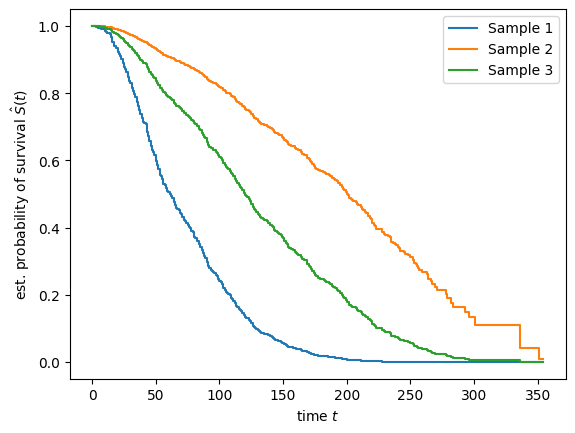

In [129]:
pred_surv = estimator.predict_survival_function(KM_pred_gen)
time_points = np.arange(0, 355)
for i, surv_func in enumerate(pred_surv):
    plt.step(time_points, surv_func(time_points), where="post",
             label="Sample %d" % (i + 1))
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

In [130]:
#Измеряем CI
prediction = estimator.predict(X_test)
result = concordance_index_censored(y_test["overall_survival"], y_test["overall_survival_months"], prediction)
result[0]

0.5945167629832857

In [131]:
#feature selection
def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j:j+1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores

scores = fit_and_score_features(X_test_gen.values, y_test_gen)
pd.Series(scores, index=X_test_gen.columns).sort_values(ascending=False)

tgfb3       0.589467
slc19a1     0.586218
chek1       0.586014
eif4ebp1    0.584194
gsk3b       0.581149
              ...   
smarcb1     0.467856
epcam       0.466309
e2f3        0.463721
tubb4a      0.461347
rad51       0.450703
Length: 489, dtype: float64

In [134]:
# Итак, гребневая регрессия
alphas = 10. ** np.linspace(-4, 4, 50)
coefficients = {}

cph = CoxPHSurvivalAnalysis()
for alpha in alphas:
    cph.set_params(alpha=alpha)
    cph.fit(X_train_gen, y_train_gen)
    key = round(alpha, 5)
    coefficients[key] = cph.coef_

coefficients = (pd.DataFrame
    .from_dict(coefficients)
    .rename_axis(index="feature", columns="alpha")
    .set_index(X_train_gen.columns))

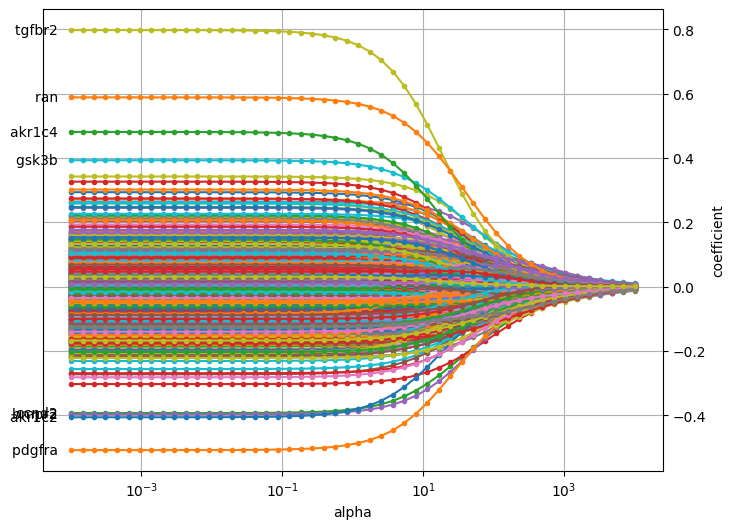

In [138]:
plot_coefficients(coefficients, n_highlight=8)

In [ ]:
#Лассо

In [139]:
cox_lasso = CoxnetSurvivalAnalysis(l1_ratio=1.0, alpha_min_ratio=0.01)
cox_lasso.fit(X_train_gen, y_train_gen)

CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, l1_ratio=1.0)

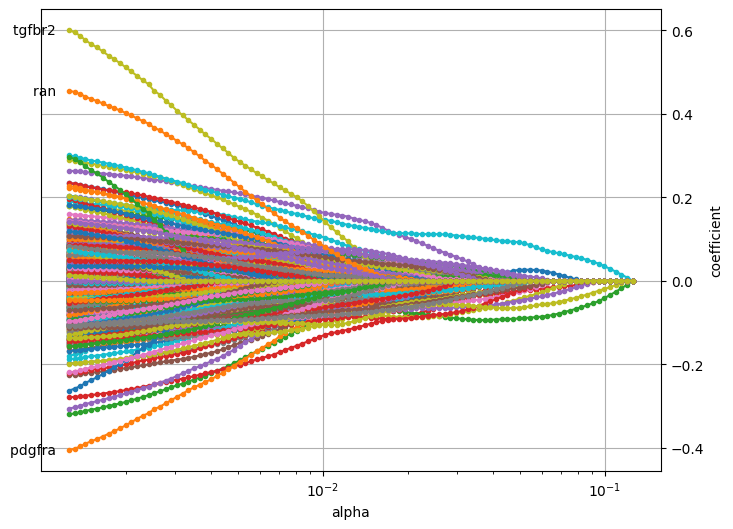

In [143]:
coefficients_lasso = pd.DataFrame(
    cox_lasso.coef_,
    index=X_train_gen.columns,
    columns=np.round(cox_lasso.alphas_, 5)
)

plot_coefficients(coefficients_lasso, n_highlight=3)

In [141]:
#эластичная сеть
cox_elastic_net = CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01)
cox_elastic_net.fit(X_train_gen, y_train_gen)

CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, l1_ratio=0.9)

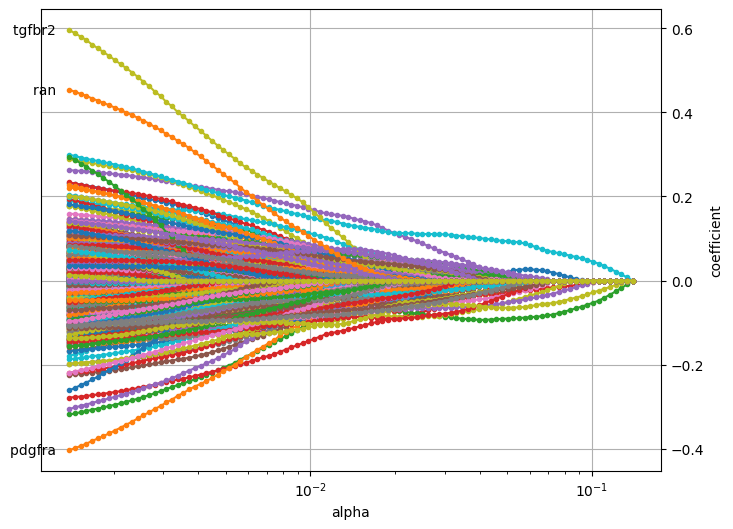

In [144]:
coefficients_elastic_net = pd.DataFrame(
    cox_elastic_net.coef_,
    index=X_train_gen.columns,
    columns=np.round(cox_elastic_net.alphas_, 5)
)

plot_coefficients(coefficients_elastic_net, n_highlight=3)